# Evaluate Machine teaching approach



In [15]:
#Setup
from fastai import *          # Quick accesss to most common functionality
from fastai.tabular import *  # Quick accesss to tabular functionality     # Access to example data provided with fastai
from fastai.vision import *
PATH="../data/"
dep_var = 'journey'
cat_names = ["detectedActivity","weekday"]
cont_names =["geoHash","minuteOfDay"]
procs = [FillMissing, Categorify, Normalize]
# Uncomment active user
#user = "tnK534JMwwfhvUEycn69HPbhqkt2" #Maria
#user = "ehaBtfOPDNZjzy1MEvjQmGo4Zv12" #Andrea
user = "hCWCulj7M1aMVyd0Fm0Eqrv8q1Q2" #Bjorn

def predict_journeys(learner,dataset):
    "This can be something that is already in the framework."
    result = 0
    accuracy = 0
    for x in range(0,dataset.shape[0]):
        correct = dataset.iloc[x].journey  #remove journey
        predicted = learner.predict(dataset.iloc[x]);
        if (str(correct)==str(predicted[0])):
            result=result+1
    accuracy=result/dataset.shape[0]
    return(accuracy)
    
def predict_journey(learner,detectedActivity,geoHash,minuteOfday,weekday):
    data = np.array([['','detectedActivity','geoHash','minuteOfDay','weekday'],
                ["row1",detectedActivity,geoHash,minuteOfday,weekday]])            
    dr=pd.DataFrame(data=data[1:,1:],
                    index=data[1:,0],
                    columns=data[0,1:]).astype(np.int64)
    predicted = learner.predict(dr.iloc[0])
    return(predicted[0],str(round(predicted[2].max().item(),2)))

def evaluate_teaching_daily(learner,testset):
    result = []
    oldDayNumber=-1
    daySet = DataFrame(testset[0:0]) #copy structure
    #for index, row in trainingset.iterrows():
    for row in testset.itertuples():
        if row[0]+1==len(testset):
            print("lastRow REALLY")
        if oldDayNumber != row[4] or row[0]+1==len(testset): #A new day!   
            if (row[0]+1==len(testset)):   ##if last line add that row
                daySet = daySet.append(testset.iloc[row[0]])
            if len(daySet)>0:
                accuracy = round(predict_journeys(learner,daySet),3)
                result.append([accuracy,oldDayNumber])
                daySet = daySet.iloc[0:0]
                daySet =daySet.append(testset.iloc[row[0]])
            else: ##it is first row or no teaching data exists(Cold start) so no training is possible
                #result.append([0,oldDayNumber])
                daySet = daySet.append(testset.iloc[row[0]])
            oldDayNumber = row[4]
        else: # same old day add the row  
            daySet = daySet.append(testset.iloc[row[0]])
    return (result)

def make_shure_we_got_enough_rows(dataset,minrows=1000):
    "If the dataset has fewer rows that minrows, whole dataset copies will be added at the end until at least minrows exists"
    newset = pd.DataFrame()
    while newset.shape[0]<minrows:
        newset = pd.concat([newset,dataset])
    return(newset)

def save_results(filename,result):
    a = np.asarray(result)
    np.savetxt("saved/"+filename,a,delimiter=',',fmt="%10.2f")

### Accuracy daily during the initial 14 days of use.

epoch,train_loss,valid_loss,accuracy
1,1.177618,1.360390,0.420000
2,0.907705,1.240094,0.870000
3,0.678288,0.818271,0.900000
4,0.508641,0.396237,1.000000
5,0.378275,0.143390,1.000000
6,0.280601,0.057858,1.000000
7,0.210633,0.029728,1.000000
8,0.158072,0.017926,1.000000
9,0.120007,0.009811,1.000000
10,0.091376,0.007914,1.000000


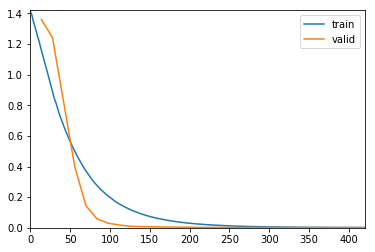

CPU times: user 7.96 s, sys: 2.84 s, total: 10.8 s
Wall time: 13.8 s


In [16]:
#%%capture
teachingSet = pd.read_csv(PATH+user+"_teaching_set.csv")
teachingSet=make_shure_we_got_enough_rows(teachingSet)
valid_idx = list(np.random.randint(0,len(teachingSet),int(len(teachingSet)*0.1)))
data = (TabularList.from_df(teachingSet, path=user, cat_names=cat_names, cont_names=cont_names, procs=procs)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var)
                .databunch())
learner=tabular_learner(data, layers=[200,100], metrics=accuracy,callback_fns=ShowGraph)
%time learner.fit_one_cycle(30)


In [17]:
testSet = pd.read_csv(PATH+user+"_test.csv")
result = predict_journeys(learner,testSet)
print("Test set accuracy: "+str(result))

Test set accuracy: 0.9253112033195021


In [23]:
the14FirstDays = pd.read_csv(PATH+user+"_start14days.csv")
result = evaluate_teaching_daily(learner,the14FirstDays)
save_results(user+"_result.csv",result)

lastRow REALLY


### Iterative training daily during the initial 14 days of use, a teaching set is added to the training data.
Here we add an idealised teaching set in the beginning of our dataset. Then we start training from day 0 using only the data in the teachingset and contiuing as in the section above.
Teachingset:

Andrea:
[Verbose](https://github.com/k3larra/commuter/blob/master/data/ehaBtfOPDNZjzy1MEvjQmGo4Zv12_teaching_set.csv)
[Minimal](../commuter/data/ehaBtfOPDNZjzy1MEvjQmGo4Zv12_teaching_set_minimal.csv)

Björn:
[Verbose](https://github.com/k3larra/commuter/blob/master/data/hCWCulj7M1aMVyd0Fm0Eqrv8q1Q2_teaching_set.csv)
[Minimal](../commuter/data/hCWCulj7M1aMVyd0Fm0Eqrv8q1Q2_teaching_set_minimal.csv)

Maria:
[Verbose](https://github.com/k3larra/commuter/blob/master/data/tnK534JMwwfhvUEycn69HPbhqkt2_teaching_set.csv)
[Minimal](../commuter/data/tnK534JMwwfhvUEycn69HPbhqkt2_teaching_set_minimal.csv)

### Show results
Prints results from training done in the cells above.

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
import pandas as pd
personas = pd.read_csv("saved/personas.csv")
#Uncomment to look at individual result for other users that the default declared above.
#user = "tnK534JMwwfhvUEycn69HPbhqkt2" #Maria
#user = "ehaBtfOPDNZjzy1MEvjQmGo4Zv12" #Andrea
#user = "hCWCulj7M1aMVyd0Fm0Eqrv8q1Q2" #Bjorn
personaname = personas.loc[personas['id']==user]
learning_ax0= pd.read_csv("saved/Iterative_time_"+user+".csv",header=None).values
teaching_ax0 = pd.read_csv("saved/Iterative_time_teach"+user+".csv",header=None).values
teaching_min_ax0 = pd.read_csv("saved/Iterative_time_teach_minimal"+user+".csv",header=None).values
supervised_min_ax0 = pd.read_csv("saved/Iterative_time_supervised"+user+".csv",header=None).values
fig, ax0 = plt.subplots()
ax0.set_title(personaname ['name'].iloc[0]+":"+user)
ax0.plot(learning_ax0[:,2],label='Iterative learning')
ax0.plot(teaching_ax0[:,2],label='Teaching')
ax0.plot(teaching_min_ax0[:,2],label='Teaching using minimal data')
ax0.plot(supervised_min_ax0[:,2],label='Pretrained model')
plt.xlabel('Time (days)')
plt.ylabel('Accuracy')
legend = ax0.legend(loc='lower right', shadow=True, fontsize='medium')
plt.show()

### Evaluate on test set
Evaluate using the test set on a trained "learner"*

#### Predict on individual journey

### Confusion Matrix and other stuff

In [19]:
preds,y,losses = learner.get_preds(with_loss=True)
interp = ClassificationInterpretation(data, preds, y, losses)

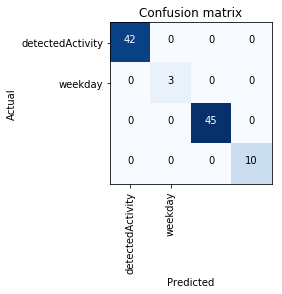

In [20]:
#Interesting but why is detectedactivity presented? It should be the journeys????
#Contue working on this since it gives information on wrong predictions. Real travels can be added so it can be read by a domai expert.
interp.plot_confusion_matrix()